## Read me

1. ``pip install tensorflow``

2. Put data files in
``cancer-net/pnet/_database``



In [1]:
%cd ../pnet
import os
wd = os.path.dirname(os.getcwd())
os.environ['PYTHONPATH'] = wd

/mnt/ceph/users/zzhang/cancer-net/pnet


In [2]:

import imp
import tensorflow as tf

from config_path import PROSTATE_LOG_PATH, POSTATE_PARAMS_PATH
from model.model_factory import get_model
from model.nn import Model

from data.data_access import Data
from data.prostate_paper.data_reader import ProstateDataPaper, load_data_type
from data.prostate_paper import data_reader

from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, accuracy_score, \
    precision_score, recall_score

2022-06-01 23:42:21.973033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/sw/pkg/devel/gcc/7.4.0/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-06-01 23:42:21.973058: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-69_iz1lp because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
params_file = './pnet/onsplit_average_reg_10_tanh_large_testing'
log_dir = os.path.join(PROSTATE_LOG_PATH, params_file)
log_dir = log_dir
params_file = os.path.join(POSTATE_PARAMS_PATH, params_file)

In [4]:
POSTATE_PARAMS_PATH

'/mnt/ceph/users/zzhang/cancer-net/pnet/train/params/P1000'

In [5]:
params_file_full = params_file + '.py'
print(params_file_full)
params = imp.load_source(params_file, params_file_full)

/mnt/ceph/users/zzhang/cancer-net/pnet/train/params/P1000/./pnet/onsplit_average_reg_10_tanh_large_testing.py


In [6]:
# model inherits a sklearn BaseEstimator
model = Model(**params.models[0]['params'])
model.get_params()


{'model_params': {'use_bias': True,
  'w_reg': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
  'w_reg_outcomes': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
  'dropout': [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
  'loss_weights': [2, 7, 20, 54, 148, 400],
  'optimizer': 'Adam',
  'activation': 'tanh',
  'data_params': {'id': 'ALL',
   'type': 'prostate_paper',
   'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
    'drop_AR': False,
    'cnv_levels': 3,
    'mut_binary': True,
    'balanced_data': False,
    'combine_type': 'union',
    'use_coding_genes_only': True,
    'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
    'training_split': 0}},
  'add_unk_genes': False,
  'shuffle_genes': False,
  'kernel_initializer': 'lecun_uniform',
  'n_hidden_layers': 5,
  'attention': False,
  'dropout_testing': False},
 'fitting_params': {'samples_per_epoch': 10,
  'select_best_model': False,
  'monitor': 'val_o6_f1',
  'verbose': 2,
  'epoch': 300,
  'shuffle':

In [7]:
ret = model.build_fn(**model.model_params)
keras_mod, feature_names = ret

{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3
self.kernel_initializer <tensorflow.python.keras.regularizers.L2 object at 0x7fffc87bbd60> <tensorflow.python.keras.initializers.initializers_v2.LecunUniform object at 0x7fffc87bbf70> <tensorflow.python.keras.regularizers.L2 object at 0x7fffc87bbd60>


2022-06-01 23:42:39.503335: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-01 23:42:39.578700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-01 23:42:39.578897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/sw/pkg/devel/gcc/7.4.0/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-06-01 23:42:39.579046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such f

input dimensions (None, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout [1, 2, 3, 4, 5] [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
layer 0, dropout  0.1 w_reg 0.001
layer 1, dropout  0.1 w_reg 0.001
layer 2, dropout  0.1 w_reg 0.001
layer 3, dropout  0.1 w_reg 0.001
layer 4, dropout  0.1 w_reg 0.001
Compiling...
loss_weights [2, 7, 20

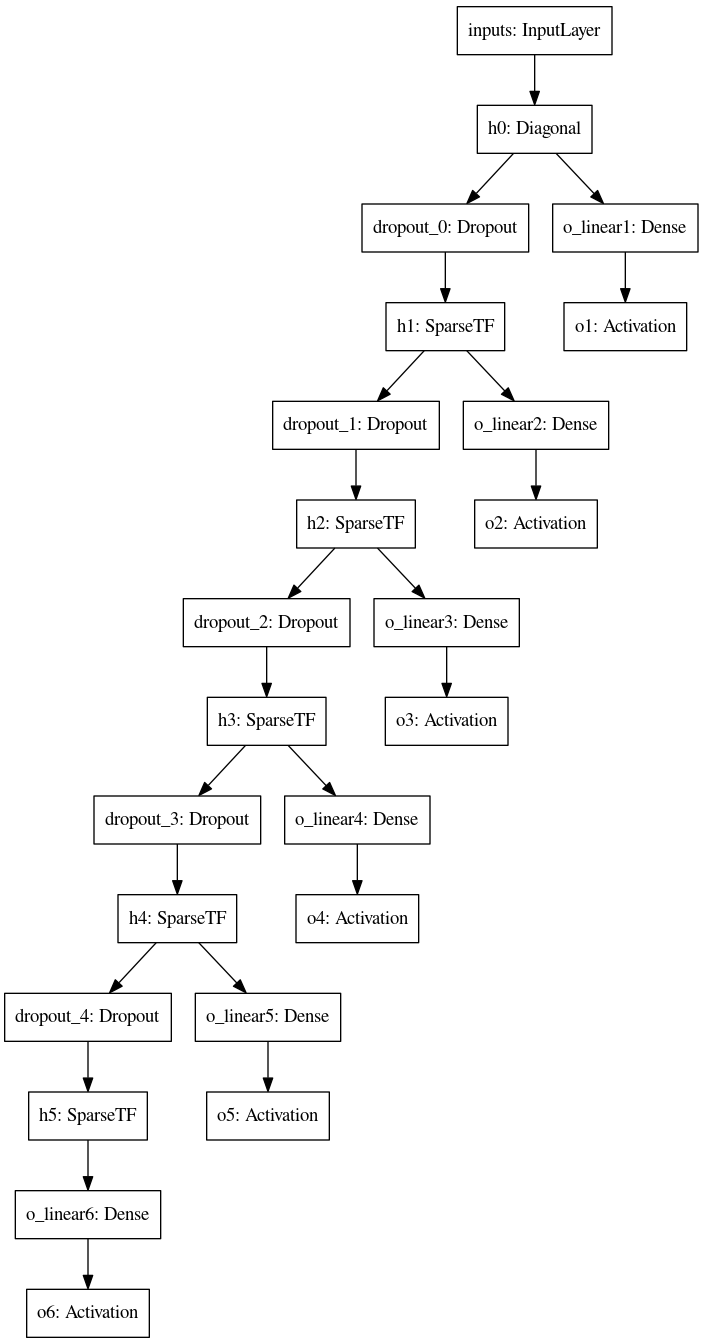

In [8]:
tf.keras.utils.plot_model(keras_mod)

In [9]:
data = Data(**params.data[0])

x_train, x_validate_, x_test_, y_train, y_validate_, y_test_, info_train, info_validate_, info_test_, cols = data.get_train_validate_test()

print(x_train.shape)

/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(807, 27687)


In [10]:
keras_mod.fit(
    x_train, y_train,
    validation_data=(x_validate_, y_validate_),
    epochs=20,
    batch_size=10,
    verbose=1
)

Epoch 1/20
input dimensions (None, 27687)

2022-06-01 23:42:54.363781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-01 23:42:54.383942: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2300000000 Hz



input dimensions (None, 27687)
81/81 [==============================] - 6s 39ms/step - loss: 412.3330 - o1_loss: 0.6410 - o2_loss: 0.6409 - o3_loss: 0.6411 - o4_loss: 0.6427 - o5_loss: 0.6478 - o6_loss: 0.6576 - o1_f1: 0.0062 - o2_f1: 0.0000e+00 - o3_f1: 0.0082 - o4_f1: 0.0000e+00 - o5_f1: 0.0000e+00 - o6_f1: 0.0000e+00 - val_loss: 398.1029 - val_o1_loss: 0.6245 - val_o2_loss: 0.6289 - val_o3_loss: 0.6295 - val_o4_loss: 0.6297 - val_o5_loss: 0.6299 - val_o6_loss: 0.6312 - val_o1_f1: 0.0000e+00 - val_o2_f1: 0.0000e+00 - val_o3_f1: 0.0000e+00 - val_o4_f1: 0.0000e+00 - val_o5_f1: 0.0000e+00 - val_o6_f1: 0.0000e+00
Epoch 2/20
81/81 [==============================] - 2s 29ms/step - loss: 400.7852 - o1_loss: 0.6200 - o2_loss: 0.6331 - o3_loss: 0.6354 - o4_loss: 0.6355 - o5_loss: 0.6352 - o6_loss: 0.6348 - o1_f1: 0.0000e+00 - o2_f1: 0.0000e+00 - o3_f1: 0.0000e+00 - o4_f1: 0.0000e+00 - o5_f1: 0.0000e+00 - o6_f1: 0.0000e+00 - val_loss: 397.3088 - val_o1_loss: 0.6131 - val_o2_loss: 0.6250 - val

Epoch 15/20
81/81 [==============================] - 2s 29ms/step - loss: 207.2524 - o1_loss: 0.3457 - o2_loss: 0.2872 - o3_loss: 0.2952 - o4_loss: 0.3070 - o5_loss: 0.3240 - o6_loss: 0.3333 - o1_f1: 0.7081 - o2_f1: 0.7445 - o3_f1: 0.7280 - o4_f1: 0.7194 - o5_f1: 0.7105 - o6_f1: 0.7145 - val_loss: 233.3960 - val_o1_loss: 0.3966 - val_o2_loss: 0.3214 - val_o3_loss: 0.3341 - val_o4_loss: 0.3492 - val_o5_loss: 0.3624 - val_o6_loss: 0.3759 - val_o1_f1: 0.4777 - val_o2_f1: 0.4619 - val_o3_f1: 0.4532 - val_o4_f1: 0.4532 - val_o5_f1: 0.4406 - val_o6_f1: 0.4406
Epoch 16/20
81/81 [==============================] - 2s 28ms/step - loss: 195.0809 - o1_loss: 0.3387 - o2_loss: 0.2772 - o3_loss: 0.2820 - o4_loss: 0.2901 - o5_loss: 0.3052 - o6_loss: 0.3128 - o1_f1: 0.7665 - o2_f1: 0.7764 - o3_f1: 0.7783 - o4_f1: 0.7679 - o5_f1: 0.7625 - o6_f1: 0.7606 - val_loss: 226.7560 - val_o1_loss: 0.3899 - val_o2_loss: 0.3176 - val_o3_loss: 0.3310 - val_o4_loss: 0.3417 - val_o5_loss: 0.3536 - val_o6_loss: 0.3636 

In [11]:
y_hat = keras_mod.predict(x_test_)

input dimensions (None, 27687)


In [12]:
ys = y_test_.flatten()
outs = y_hat[-1]

fpr_valid, tpr_valid, _ = roc_curve(ys, outs)
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs))
print('f1', f1_score(ys, outs>0.5))
print('precision', precision_score(ys, outs>0.5))
print('recall', recall_score(ys, outs>0.5))

accuracy 0.8725490196078431
auc 0.9282006920415226
aupr 0.8944832358489969
f1 0.7868852459016393
precision 0.8888888888888888
recall 0.7058823529411765
